## Устанока зависимостей

In [ ]:

!pip install kaggle
!pip install implicit
!pip install lightfm

#### Предполагается запуск на Google Colab. Для этого необходимо получить API-ключ на Kaggle и его загрузить. После произойдет загрузка архива данных и его распаковка (Можно просто загрузить датасет в данную директорию).

## Загрузка данных через kaggle api

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [3]:
#Make a directory named kaggle and copy the kaggle.json file there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d grouplens/movielens-20m-dataset

 96% 188M/195M [00:01<00:00, 174MB/s]
100% 195M/195M [00:01<00:00, 181MB/s]


In [5]:
from zipfile import ZipFile
file_name = 'movielens-20m-dataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as ip:
  ip.extractall()
  print('Done')

Done


## Импорт библиотек

In [6]:
import pandas as pd
import sklearn
import numpy as np

import os

import lightfm
from lightfm.evaluation import auc_score, precision_at_k

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random

import implicit
from implicit import evaluation

/usr/local/lib/python3.7/dist-packages/implicit/gpu/__init__.py:14: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  f"CUDA extension is built, but disabling GPU support because of '{e}'",


## Загрузка файлов

In [8]:
tag = pd.read_csv('tag.csv')
movie = pd.read_csv('movie.csv')
rating = pd.read_csv('rating.csv')

In [9]:
tag.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [10]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


#### Выведем минимальнyю и максимальную оценку фильмов, выставленную пользователями.  

In [12]:
min, max = rating.rating.min(), rating.rating.max()
min, max

(0.5, 5.0)

In [13]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


#### Рассмотрим распредление оценок

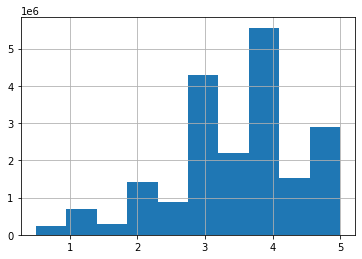

In [14]:
rating.rating.hist()

## Выбор метрики

### В качестве метрики для системы рекоммендации была выбрана - ${precision@k}$, точность построенная на топ k значениях. То есть это доля рекоммендуемых элементов в топе, которые релевантны. 

## Валидация

### В данном случае (из-за отсутствия времени) валидация будет проводиться на отложенной выборке. В данном случае обучающая выборка разбивается один раз и производится обучение. Такой подход подходит для больших датасетов (наш клиент), так как ребует меньше вычислительных мощностей. Конечно, оценка существенно зависит от разбиения, хотя большой датасет существенно снижает дисперсию модели

## Поиск гиперпараметров модели

### Гиперпараметры модели ML - это параметры модели, которые не настраиваются в процессе обучения. Для подбора гиперпараметров, данные делятся на: тренировочный набор, валидационный набор, тестовый набор. Это должно предотвратить переобучение на влидационнои наборе. Далее использовать поиск по сетке, случайний поиск по сетке, байсовскую оптимизацию. Также можно последовательно перебирать гиперпарметры "ручками" (что и было сделано в данной работе и имеет место).

## Implicit

#### Реализация коллаборативной фильтрации с использованием оценок. В задании было предложено несколько алгоритмов. Я использовал алгоритм факторизации, который раскладывает исходную матрицу признаков, убирая шум и оставляя полезный сигнал. Примером такого алгоритма является SVD: 
$R=U*D*S$
#### U — компактное описание предпочтений пользователя, S — компактное описание характеристик продукта. Важно отметить, что SVD является неинтерпретируемой моделью.
#### В данном случае реализован ALS (alternating least squares) — популярный  итеративный алгоритм разложения матрицы предпочтений на произведение факторов пользователей и факторов товаров. Работает по принципу минимизации среднеквадратичной ошибки на проставленных рейтингах. Оптимизация происходит поочередно, сначала по факторам пользователей, потом по факторам товаров. Также для обхода переобучения к среднеквадратичной ошибке добавляются регуляризационные коэффиценты.

In [25]:
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import implicit
from implicit import evaluation

### Ключевые гиперпараметры данной модели:
#### 1) factors - количество факторов (скрытых описаний предпочтений)
#### 2) regularization - коэффициент регуляризации
#### 3) iterations -  количество эпох при обучении

In [26]:
# train test split

In [27]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [28]:
# Сформируем разряженную матрицу пользователь-продукт
# sparse_item_user = sparse.csr_matrix((rating.rating.astype(float), (rating.movieId, rating.userId)))
sparse_user_item = sparse.csr_matrix((rating.rating.astype(float), (rating.userId, rating.movieId)))

In [29]:
# Разделим датасет
train, test = evaluation.train_test_split(sparse_user_item, train_percentage=0.8, random_state=2022)

In [30]:
# Используем модель AlternatingLeastSquares
als = implicit.als.AlternatingLeastSquares(factors=5, regularization=0.1, iterations=20)

In [31]:
# Обучим модель
alpha_val = 15
data_conf = (train * alpha_val).astype('double')

als.fit(data_conf)

  0%|          | 0/20 [00:00<?, ?it/s]

#### Сделаем рекомендации

In [32]:
user_id = 134
recs = als.recommend(user_id, train[user_id], N=15)

In [33]:
movies_list = []
scores = []

for item, score in zip(recs[0], recs[1]):
  movies_list.append(movie[movie.movieId == item].title.values[0])
  scores.append(score)

df = pd.DataFrame({'movie': movies_list, 'scores': scores})
df

,movie,scores
0,"20,000 Leagues Under the Sea (1954)",1.102049
1,Private Benjamin (1980),1.087252
2,Real Genius (1985),1.085475
3,Old Yeller (1957),1.076701
4,Strange Days (1995),1.073990
5,In & Out (1997),1.066806
6,Courage Under Fire (1996),1.064493
7,Bound (1996),1.062498
8,Star Trek II: The Wrath of Khan (1982),1.062417
9,Rising Sun (1993),1.061992


In [34]:
# Посчитаем метрику на тестовой выборке
evaluation.precision_at_k(als, train, test, K=10, num_threads=4)

  0%|          | 0/138334 [00:00<?, ?it/s]

0.2110370368464433

## LightFM

#### LightFM является гибридной моделью рекомендаций со скрытым представлением. Специфика работы данной модели требует, чтобы мы убрали все рейтинги с низкими баллами, и строили рекомендации, обучаясь на наборе с более высокими

### Ключевые гиперпараметры данной модели:
#### 1) no_components  - количество факторов (скрытых описаний предпочтений)
#### 2) loss  - функция потерь
#### 3) learning_rate  -  скорость обучения
#### 4) item_alpha, user_alpha - коэффициенты регуляризации

In [34]:
rating = rating[rating.rating > 4]

### TAG

In [35]:
# Создадим матрицу взаимодйствия (пользователь - тег)

from lightfm.data import Dataset

dataset = Dataset()
dataset.fit((rating.userId.tolist()),
            (rating.movieId.tolist()))

In [36]:
dataset.interactions_shape()

(136472, 17218)

In [37]:
dataset.fit_partial(items=(tag.movieId.tolist()),
                    item_features=(tag.tag.tolist()))

In [38]:

item_features = dataset.build_item_features(((mvId, [tg])
                                              for mvId, tg in zip(tag.movieId.tolist(), tag.tag.tolist())))

In [39]:
(interactions, weights) = dataset.build_interactions(((usrId, mvId)
                                                      for usrId, mvId in zip(rating.userId.tolist(), rating.movieId.tolist())))

In [42]:
# Разделим набор данных на тестовый и тренировочный

from lightfm import cross_validation
train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2, random_state=2022)

In [43]:
# Обучим модель

from lightfm import LightFM

model = LightFM(loss='bpr')
model.fit(train, item_features=item_features)

In [44]:
# Получим словари для корректного отображения рекоммендаций
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()

#### Сделаем рекоммендации

In [54]:
mv = []
for i in pd.unique(tag.movieId):
  mv.append(item_id_map[i])
mv = np.array(mv)

In [72]:
user_id = 134
user_id = user_id_map[user_id]

print_df = []
print_df_scores = []
predictions = model.predict(np.array([user_id]*len(mv)), np.array(mv), item_features=item_features)
top_items = mv[np.argsort(-predictions)][:11]
scores = np.sort(-predictions)[:11]
for ind, score in zip(top_items, scores):
  print_df.append(movie[movie.movieId == dict([(v, k) for k, v in item_id_map.items()])[ind]].title.values[0])
  print_df_scores.append(-score)

df = pd.DataFrame({'title': print_df, 'score': print_df_scores})
df

,title,score
0,29 Palms (2002),0.177001
1,"Shawshank Redemption, The (1994)",-0.004595
2,Setup (Set Up) (2011),-0.046216
3,Circus (2000),-0.049672
4,"Godfather, The (1972)",-0.052864
5,Genocide (1982),-0.060053
6,Pulp Fiction (1994),-0.061093
7,"Krays, The (1990)",-0.063360
8,Guilty (Présumé coupable) (2011),-0.076052
9,"Goebbels Experiment, The (Das Goebbels Experim...",-0.077476


In [68]:
# Рассчитаем метрику на тестовом наборе
precision_at_k(model, test, k=10, item_features=item_features).mean()

0.020049777

### GENRES

In [73]:
# Создадим матрицу взаимодействия (пользователь - фильм)

from lightfm.data import Dataset

ds = Dataset()
ds.fit((rating.userId.tolist()),
            (rating.movieId.tolist()))

In [74]:
genres = []
for m in movie.genres:
  genres.extend(m.split('|'))
genres = set(genres)

In [75]:
ds.fit_partial(items=(movie.movieId.tolist()),
                    item_features=([tuple(m.split('|')) for m in movie.genres]))

In [76]:

item_features = ds.build_item_features(((mvId, [tuple(genre.split('|'))])
                                              for mvId, genre in zip(movie.movieId.tolist(), movie.genres.tolist())))

In [77]:
(interactions, weights) = ds.build_interactions(((usrId, mvId)
                                                      for usrId, mvId in zip(rating.userId.tolist(), rating.movieId.tolist())))

In [78]:
# Разделим данные на тестовую и тренировочную части
from lightfm import cross_validation
train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2, random_state=2022)

In [79]:
# Обучим модель
from lightfm import LightFM

model = LightFM(loss='bpr')
model.fit(train, item_features=item_features)

#### Сделаем предсказания

In [82]:
user_id_map, user_feature_map, item_id_map, item_feature_map = ds.mapping()
mv = []
for i in pd.unique(tag.movieId):
  mv.append(item_id_map[i])

mv = np.array(mv)

In [83]:
user_id = 134
user_id = user_id_map[user_id]

print_df = []
print_df_scores = []
predictions = model.predict(np.array([user_id]*len(mv)), np.array(mv), item_features=item_features)
top_items = mv[np.argsort(-predictions)][:11]
scores = np.sort(-predictions)[:11]
for ind, score in zip(top_items, scores):
  print_df.append(movie[movie.movieId == dict([(v, k) for k, v in item_id_map.items()])[ind]].title.values[0])
  print_df_scores.append(-score)

df = pd.DataFrame({'title': print_df, 'score': print_df_scores})
df

,title,score
0,One Flew Over the Cuckoo's Nest (1975),0.365690
1,Casablanca (1942),0.364211
2,American Beauty (1999),0.344768
3,Schindler's List (1993),0.315765
4,Citizen Kane (1941),0.313506
5,"Graduate, The (1967)",0.305268
6,"Godfather, The (1972)",0.304061
7,To Kill a Mockingbird (1962),0.297167
8,Amadeus (1984),0.283722
9,Raging Bull (1980),0.257956


In [85]:
# Посчитаем метрику на тестовом наборе
precision_at_k(model, test, k=10, item_features=item_features).mean()

0.045994874

### GENRES + TAG

## Результаты

#### В данном случае, коллаборативный метод фильтрации показал себя лучше (в плане метрики и скорости обучения). Скорее всего это произошло, потому что в случае lightFM был обрезан датасет (изначально на полном наборе, результат lightFM был больше 0.5 на метрике точность в топе 10). Также не успел реализовать lightFM, где с помощью метода fit_partial (реализованного как в классе Dataset, так и LightFM) объеденил бы матрицу взаимодействий пользователь-тэг, пользователь-фильм. Также интересным вариантом является испльзование комбинаций  lightFM и преобразователем названий фильмов в веткторное пространство ${tf-idf}$